In [ ]:

import pandas as pd


import re
import pandas as pd

from sklearn.preprocessing import MinMaxScaler




for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/all_data.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/holistic_scores.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_ell.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_arguments.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/ell.csv
/kaggle/input/persuade-2-0/persuade_corpus_1.0.csv
/kaggle/input/persuade-2-0/persuade_2.0_human_scores_demo_id_github.csv
/kaggle/input/persuade-2-0/AES2-persuade.csv
/kaggle/input/asap-2-0/ASAP2_train_sourcetexts.csv


In [ ]:



def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)              
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r"[^a-z0-9.,!?'\s]", ' ', text)      
    text = re.sub(r'\s+', ' ', text).strip()           
    return text


def load_dataset(scale_scores=True, min_len=30):

    df1 = pd.read_csv("/kaggle/input/asap-2-0/ASAP2_train_sourcetexts.csv") 
    df2 = pd.read_csv("/kaggle/input/persuade-2-0/persuade_2.0_human_scores_demo_id_github.csv")
    df3 = pd.read_csv("/kaggle/input/persuade-2-0/AES2-persuade.csv")
    df4 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/all_data.csv")
    df5 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/holistic_scores.csv")
    df6 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_ell.csv")
    df7 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_arguments.csv")


    for df in [df2, df4, df5, df6, df7]:
        df.rename(columns={'holistic_essay_score': 'score'}, inplace=True)

    df = pd.concat([
        df1[['full_text', 'score']],
        df2[['full_text', 'score']],
        df3[['full_text', 'score']],
        df5[['full_text', 'score']],
        df6[['full_text', 'score']],
        df7[['full_text', 'score']]
    ], ignore_index=True)

    if scale_scores:
        scaler_main = MinMaxScaler()
        df['score'] = scaler_main.fit_transform(df[['score']])

        scaler_df4 = MinMaxScaler()
        df4['score'] = scaler_df4.fit_transform(df4[['score']])  

    df = pd.concat([
        df[['full_text', 'score']],
        df4[['full_text', 'score']]
    ], ignore_index=True)


    df = df.dropna(subset=['full_text', 'score'])
    df = df.drop_duplicates(subset='full_text').reset_index(drop=True)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    df = df[df['full_text'].str.strip() != ""]
    df['essay'] = df['full_text'].apply(clean_text)
    df = df[df['essay'].str.split().apply(len) >= min_len]
    df = df[['essay', 'score']]

    return df



In [3]:
df = load_dataset()

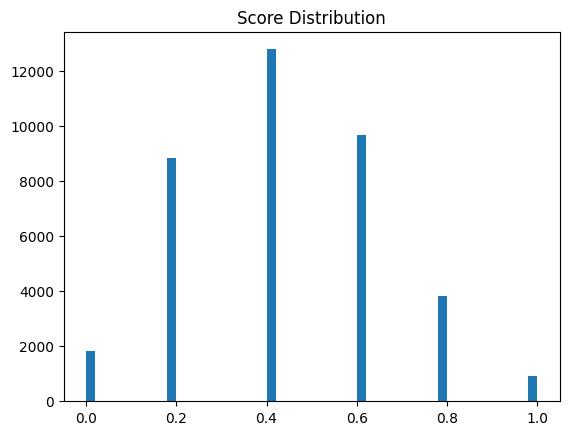

In [4]:
import matplotlib.pyplot as plt
plt.hist(df['score'], bins=50)
plt.title("Score Distribution")
plt.show()


In [5]:
df['score'] = df['score'].apply(lambda x: 0.20 if x == 0.25 else x)

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm



rare_df = df[(df['score'] < 0.1) | (df['score'] > 0.7)]

tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


def paraphrase(text, num_return_sequences=5):
    input_text = f"paraphrase: {text} </s>"
    inputs = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512)
    inputs = inputs.to(model.device)
    outputs = model.generate(
        inputs,
        max_length=512,
        num_beams=5,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    return [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

augmented_texts = []
augmented_scores = []


for _, row in tqdm(rare_df.iterrows(), total=len(rare_df)):
    try:
        new_versions = paraphrase(row['essay'], num_return_sequences=2)
        augmented_texts.extend(new_versions)
        augmented_scores.extend([row['score']] * len(new_versions))
    except Exception as e:
        continue

aug_df = pd.DataFrame({
    'essay': augmented_texts,
    'score': augmented_scores
})


balanced_df = pd.concat([df, aug_df]).sample(frac=1).reset_index(drop=True)


balanced_df['score'].hist(bins=20)


Augmenting underrepresented essays...


 78%|███████▊  | 5108/6581 [2:57:10<50:39,  2.06s/it]  

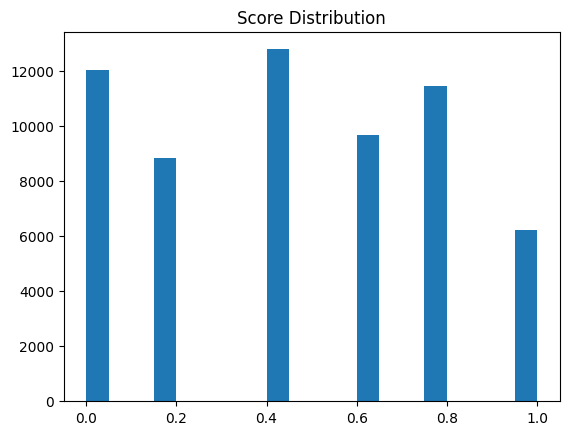

In [23]:
import matplotlib.pyplot as plt
plt.hist(df['score'], bins=20)
plt.title("Score Distribution")
plt.show()

In [24]:
df["score"].value_counts()

score
0.4    12781
0.0    12016
0.8    11434
0.6     9656
0.2     8833
1.0     6216
Name: count, dtype: int64